# This notebook will use features that only investors see in LC

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('lending_club_ml.csv')
df.drop(['id'], inplace=True, axis=1)

In [4]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_a

Sample look

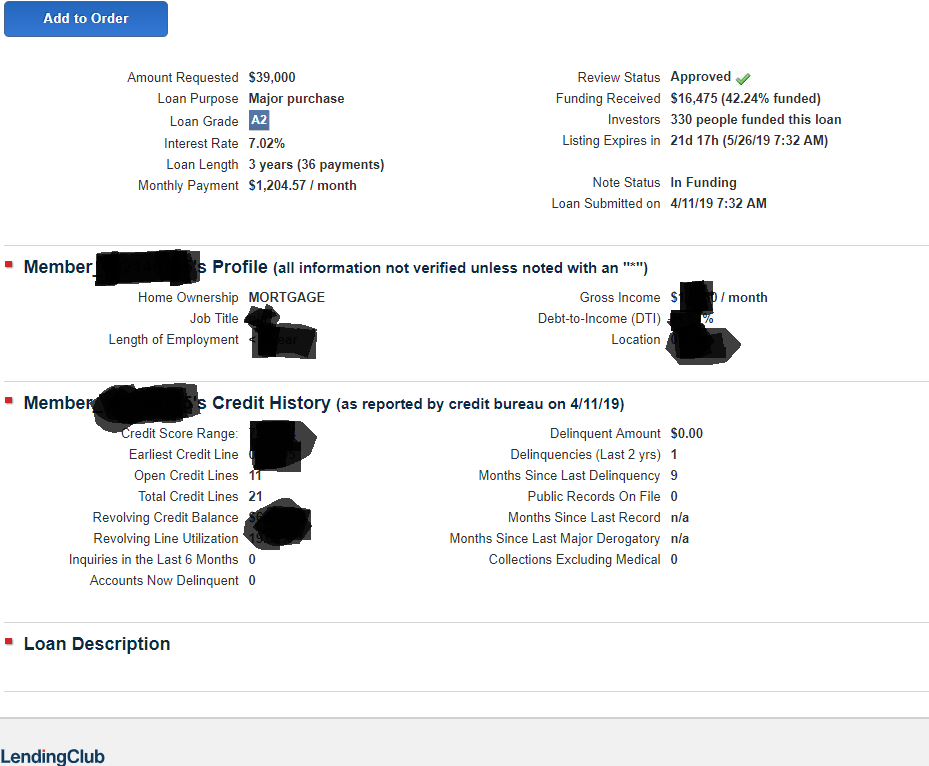

In [5]:
#investor only features
df_lc = df[['loan_status','loan_amnt','purpose','sub_grade','int_rate','term',  'installment', 
            'home_ownership','emp_length',  'annual_inc','dti', 
            'fico_range_low','fico_range_high','open_acc','total_acc','revol_bal','revol_util','inq_last_6mths','acc_now_delinq',
            'delinq_amnt','delinq_2yrs','mths_since_last_delinq','pub_rec','mths_since_last_record','mths_since_last_major_derog','collections_12_mths_ex_med']]

In [6]:
# dummy variables
# I have decided to use subgrade and not grade as these are suppose to be similar features but, subgrade is more granular

df_lc = pd.concat([df_lc, pd.get_dummies(df_lc.sub_grade, prefix='sub_grade', drop_first=True)], axis=1)
df_lc = pd.concat([df_lc, pd.get_dummies(df_lc.home_ownership,prefix='home_ownership', drop_first=True)], axis=1)
df_lc = pd.concat([df_lc, pd.get_dummies(df_lc.purpose, prefix='purpose', drop_first=True)], axis=1)

df_lc.drop(columns=['sub_grade', 'home_ownership' ,'purpose'], inplace=True)


In [7]:
#fill all nans with 0
df_lc.fillna(0, inplace=True)

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


def scoring(clf, x, y):
    
    #Baseline
    print('Loan passing rate:', np.mean(y))
    print('Balanced loan passing rate:', np.average(y, weights=x['loan_amnt']))
    print('\n')
    
    
    print('score: ', clf.score(x, y))
    # score adjusted for loan amount
    print('balanced_accuracy_score: ', balanced_accuracy_score(
        y, clf.predict(x), sample_weight=x['loan_amnt']))

    print(confusion_matrix(y, clf.predict(x)))
    
    print('F1 score: ', f1_score(y, clf.predict(x)))
    
    print('precision_score: ', precision_score(y, clf.predict(x)))

    # score adjusted for loan amount
    print('average_precision_score: ', average_precision_score(
        y, clf.predict(x), average='weighted', sample_weight=x['loan_amnt']))
    
    print('recall_score: ', recall_score(y, clf.predict(x)))

    print('roc: ', roc_auc_score(y, clf.predict_proba(x)[:, 1]))

    # score adjusted for loan amount
    print('roc_weighted: ', roc_auc_score(y, clf.predict_proba(x)[
          :, 1], average='weighted', sample_weight=x['loan_amnt']))

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_lc.drop(['loan_status'], axis=1)
y = df_lc.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



rf_best = RandomForestClassifier(criterion= 'entropy', n_estimators= 101)
rf_best.fit(X_train, y_train)
    
print('RANDOM FOREST')
scoring(rf_best, X_test, y_test)

RANDOM FOREST
Loan passing rate: 0.8009672589365736
Balanced loan passing rate: 0.7855872316459166


score:  0.9409804500400254
balanced_accuracy_score:  0.8607788070891884
[[108231  41446]
 [  2938 599407]]
F1 score:  0.964298526863782
precision_score:  0.9353268222197603
average_precision_score:  0.9295420464779849
recall_score:  0.9951223966331587
roc:  0.9613777442272333
roc_weighted:  0.9624936174655171


In [10]:
scoring(rf_best, X_train, y_train)

Loan passing rate: 0.8015205879469954
Balanced loan passing rate: 0.7865164321952773


score:  0.9999954408576659
balanced_accuracy_score:  0.9999893672741798
[[ 348267       8]
 [      0 1406441]]
F1 score:  0.9999971559499304
precision_score:  0.9999943119160382
average_precision_score:  0.9999942279676592
recall_score:  1.0
roc:  1.0
roc_weighted:  1.0


In [11]:
df_importance = pd.DataFrame(index=X.columns,data=rf_best.feature_importances_,columns=['importance'])
df_importance.sort_values(by=['importance'],ascending =False)

,importance
int_rate,0.082213
dti,0.081239
revol_bal,0.076105
revol_util,0.074020
installment,0.070618
annual_inc,0.069550
total_acc,0.062106
loan_amnt,0.056744
open_acc,0.052816
mths_since_last_delinq,0.041606
